# Import Packages

In [1]:
import pandas as pd
from pandas import tseries
import numpy as np
import unicodedata
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC # KJ: force it to be a line
from sklearn.svm import SVC # KJ: and then let it wiggle
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi']= 300

/Users/kellyjones/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Data

## Table: Person

In [2]:
df_person = pd.read_csv('data/2015-traffic-fatalities/person.csv')

In [3]:
df_person.columns

Index(['STATE', 'ST_CASE', 'VE_FORMS', 'VEH_NO', 'PER_NO', 'STR_VEH', 'COUNTY',
       'DAY', 'MONTH', 'HOUR', 'MINUTE', 'RUR_URB', 'FUNC_SYS', 'HARM_EV',
       'MAN_COLL', 'SCH_BUS', 'MAKE', 'MAK_MOD', 'BODY_TYP', 'MOD_YEAR',
       'TOW_VEH', 'SPEC_USE', 'EMER_USE', 'ROLLOVER', 'IMPACT1', 'FIRE_EXP',
       'AGE', 'SEX', 'PER_TYP', 'INJ_SEV', 'SEAT_POS', 'REST_USE', 'REST_MIS',
       'AIR_BAG', 'EJECTION', 'EJ_PATH', 'EXTRICAT', 'DRINKING', 'ALC_DET',
       'ALC_STATUS', 'ATST_TYP', 'ALC_RES', 'DRUGS', 'DRUG_DET', 'DSTATUS',
       'DRUGTST1', 'DRUGTST2', 'DRUGTST3', 'DRUGRES1', 'DRUGRES2', 'DRUGRES3',
       'HOSPITAL', 'DOA', 'DEATH_DA', 'DEATH_MO', 'DEATH_YR', 'DEATH_HR',
       'DEATH_MN', 'DEATH_TM', 'LAG_HRS', 'LAG_MINS', 'P_SF1', 'P_SF2',
       'P_SF3', 'WORK_INJ', 'HISPANIC', 'RACE', 'LOCATION'],
      dtype='object')

In [4]:
df_person = df_person[['STATE', 'ST_CASE', 'VEH_NO', 'PER_NO', 'COUNTY','HARM_EV', 'MAN_COLL', 
                       'SCH_BUS', 'BODY_TYP', 'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP',
                       'AGE', 'SEX', 'PER_TYP', 'INJ_SEV', 'SEAT_POS', 'REST_USE', 'REST_MIS',
                       'AIR_BAG', 'EJECTION', 'EXTRICAT', 'DRINKING', 'DRUGS','HOSPITAL', 
                       'DOA'
                      ]]

In [5]:
df_person.sample(5)

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,...,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EXTRICAT,DRINKING,DRUGS,HOSPITAL,DOA
77517,53,530192,1,3,41,8,0,0,14.0,2010.0,...,21,3,0,8,0,0,8,8,0,0
29060,18,180268,1,1,177,12,1,0,66.0,2015.0,...,11,8,0,9,0,9,0,0,0,7
30516,19,190073,1,1,79,8,0,0,66.0,2015.0,...,11,3,0,0,0,0,0,0,0,0
53018,37,370989,2,3,151,12,6,0,20.0,2010.0,...,23,3,0,0,0,0,8,8,5,0
79836,55,550360,1,2,111,12,6,0,14.0,2016.0,...,13,3,0,9,0,0,8,8,1,0


In [6]:
df_person.shape

(80587, 27)

In [7]:
df_person.groupby(['INJ_SEV'])['ST_CASE'].count()

INJ_SEV
0    19704
1     7400
2     9045
3     8324
4    35092
5      250
6        2
9      770
Name: ST_CASE, dtype: int64

**Person Type** (appx - codes changed by year)  
1 Driver (in trans)  
2 Passenger (in trans)  
3 Occupant (not in transport)  
4 Occupant - non motor vehicle  
5 Pedestrian  
6 Bicyclist  
7 Other cyclist  
8 Person on personal conveyance  
9 Unknown occupant type (in trans)  
10 Persons in/on buildings  
19 Unknown type of non-motorist

In [8]:
df_person.groupby(['PER_TYP'])['ST_CASE'].count()
# want to keep drivers (N=48,613) and passengers (N=24,646)

PER_TYP
1     48613
2     24646
3       286
4        66
5      5795
6       851
7         1
8       167
9       131
10       30
19        1
Name: ST_CASE, dtype: int64

In [9]:
# keep drivers and passengers
df_person = df_person[(df_person.PER_TYP == 1) | (df_person.PER_TYP == 2)]

In [10]:
df_person.shape

(73259, 27)

In [11]:
# check values
df_person.groupby(['PER_TYP'])['ST_CASE'].count()

PER_TYP
1    48613
2    24646
Name: ST_CASE, dtype: int64

**Injury Severity**  
0 No apparent injury  
1 Possible injury  
2 Suspected minor injury  
3 Suspected serious injury  
4 Fatal injury  
5 Injured, severity unknown  
6 Died prior to crash  
8 Not reported  
9 Unknown

In [12]:
df_person.groupby(['INJ_SEV'])['ST_CASE'].count()
# Fatalities N=28,597 :(

INJ_SEV
0    19517
1     7283
2     8827
3     8042
4    28597
5      245
6        2
9      746
Name: ST_CASE, dtype: int64

In [13]:
df_person.groupby(['PER_TYP','INJ_SEV'])['ST_CASE'].count()
# Far more driver fatalities than passengers. 
# Will want to check how many people who died were driving alone

PER_TYP  INJ_SEV
1        0          13576
         1           3813
         2           4590
         3           3774
         4          22150
         5            103
         6              2
         9            605
2        0           5941
         1           3470
         2           4237
         3           4268
         4           6447
         5            142
         9            141
Name: ST_CASE, dtype: int64

In [14]:
df_person.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73259 entries, 0 to 80586
Data columns (total 27 columns):
STATE       73259 non-null int64
ST_CASE     73259 non-null int64
VEH_NO      73259 non-null int64
PER_NO      73259 non-null int64
COUNTY      73259 non-null int64
HARM_EV     73259 non-null int64
MAN_COLL    73259 non-null int64
SCH_BUS     73259 non-null int64
BODY_TYP    73259 non-null float64
MOD_YEAR    73259 non-null float64
TOW_VEH     73259 non-null float64
ROLLOVER    73259 non-null float64
FIRE_EXP    73259 non-null float64
AGE         73259 non-null int64
SEX         73259 non-null int64
PER_TYP     73259 non-null int64
INJ_SEV     73259 non-null int64
SEAT_POS    73259 non-null int64
REST_USE    73259 non-null int64
REST_MIS    73259 non-null int64
AIR_BAG     73259 non-null int64
EJECTION    73259 non-null int64
EXTRICAT    73259 non-null int64
DRINKING    73259 non-null int64
DRUGS       73259 non-null int64
HOSPITAL    73259 non-null int64
DOA         73259 non-n

In [15]:
# change data types of floats to int
df_person[['BODY_TYP', 'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP']] = df_person[[
    'BODY_TYP', 'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP']].astype(int)

## Table: Accident

In [95]:
df_accident = pd.read_csv('data/2015-traffic-fatalities/accident.csv')

In [96]:
df_person.columns # what we already have

Index(['STATE', 'ST_CASE', 'VEH_NO', 'PER_NO', 'COUNTY', 'HARM_EV', 'MAN_COLL',
       'SCH_BUS', 'BODY_TYP', 'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP',
       'AGE', 'SEX', 'PER_TYP', 'INJ_SEV', 'SEAT_POS', 'REST_USE', 'REST_MIS',
       'AIR_BAG', 'EJECTION', 'EXTRICAT', 'DRINKING', 'DRUGS', 'HOSPITAL',
       'DOA'],
      dtype='object')

In [97]:
df_accident.columns # want to pull some of these

Index(['STATE', 'ST_CASE', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS',
       'PERNOTMVIT', 'PERMVIT', 'PERSONS', 'COUNTY', 'CITY', 'DAY', 'MONTH',
       'YEAR', 'DAY_WEEK', 'HOUR', 'MINUTE', 'NHS', 'RUR_URB', 'FUNC_SYS',
       'RD_OWNER', 'ROUTE', 'TWAY_ID', 'TWAY_ID2', 'MILEPT', 'LATITUDE',
       'LONGITUD', 'SP_JUR', 'HARM_EV', 'MAN_COLL', 'RELJCT1', 'RELJCT2',
       'TYP_INT', 'WRK_ZONE', 'REL_ROAD', 'LGT_COND', 'WEATHER1', 'WEATHER2',
       'WEATHER', 'SCH_BUS', 'RAIL', 'NOT_HOUR', 'NOT_MIN', 'ARR_HOUR',
       'ARR_MIN', 'HOSP_HR', 'HOSP_MN', 'CF1', 'CF2', 'CF3', 'FATALS',
       'DRUNK_DR'],
      dtype='object')

In [98]:
df_accident = df_accident[['ST_CASE', 'STATE', 'SCH_BUS', 'PEDS', 'PERSONS', 'CITY', 'DAY', 'MONTH', 'YEAR', 'DAY_WEEK', 
                           'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUD', 'LGT_COND', 'WEATHER1', 
                           'WEATHER2', 'WEATHER', 'NOT_HOUR', 'NOT_MIN', 'ARR_HOUR', 
                           'ARR_MIN', 'CF1', 'CF2', 'CF3', 'FATALS', 'DRUNK_DR']]

In [99]:
df_accident.shape # has 27 columns and over 32K observations

(32166, 27)

In [100]:
df_accident.sample(5)

,ST_CASE,STATE,SCH_BUS,PEDS,PERSONS,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,LATITUDE,LONGITUD,LGT_COND,WEATHER1,WEATHER2,WEATHER,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,CF1,CF2,CF3,FATALS,DRUNK_DR
24606,421049,42,0,1,3,4380,8,11,2015,1,18,45,40.832783,-75.708528,3,1,0,1,99,99,99,99,0,0,0,1,0
22899,400343,40,0,0,2,3170,15,8,2015,7,20,46,35.464236,-97.413256,3,1,0,1,99,99,99,99,0,0,0,1,0
5446,80402,8,0,0,2,600,2,10,2015,6,20,56,39.781017,-104.749228,3,1,0,1,20,58,21,5,0,0,0,1,1
8031,122173,12,0,0,1,0,31,10,2015,7,23,44,26.891211,-81.997881,3,10,0,10,99,99,99,99,0,0,0,1,0
8681,130029,13,0,1,1,0,11,1,2015,1,19,40,33.607900,-85.084231,2,10,0,10,19,28,19,32,0,0,0,1,0


In [101]:
df_accident['WEATHER1'].describe

<bound method NDFrame.describe of 0         1
1        10
2         1
3        10
4         1
5         1
6         1
7         2
8        10
9         1
10        1
11        1
12        1
13       10
14        1
15       10
16       10
17        1
18        1
19        2
20        2
21        1
22        5
23        1
24        1
25       10
26        1
27        1
28        2
29        1
         ..
32136     1
32137     1
32138     1
32139    10
32140     1
32141     1
32142     1
32143     1
32144    10
32145     1
32146     1
32147     1
32148     2
32149    99
32150     1
32151    10
32152     1
32153     1
32154     1
32155     1
32156     1
32157     1
32158     1
32159     1
32160     1
32161     1
32162     1
32163     1
32164     4
32165     1
Name: WEATHER1, Length: 32166, dtype: int64>

In [102]:
df_accident['WEATHER1'].isnull().sum().sum() # weather has no nulls in accident file

0

## Table: Vehicle

In [24]:
df_vehicle = pd.read_csv('data/2015-traffic-fatalities/vehicle.csv', encoding='ISO-8859-1')
# Not sure why encoding was different on this file

In [25]:
df_vehicle.head()

,STATE,ST_CASE,VEH_NO,VE_FORMS,NUMOCCS,DAY,MONTH,HOUR,MINUTE,HARM_EV,...,VTRAFCON,VTCONT_F,P_CRASH1,P_CRASH2,P_CRASH3,PCRASH4,PCRASH5,ACC_TYPE,DEATHS,DR_DRINK
0,1,10001,1,1,1,1,1,2,40,35,...,0,0,14,13,99,1,4,1,1,1
1,1,10002,1,1,1,1,1,22,13,34,...,0,0,14,6,1,4,4,7,1,0
2,1,10003,1,1,2,1,1,1,25,42,...,0,0,1,13,1,1,4,1,1,1
3,1,10004,1,1,1,4,1,0,57,53,...,0,0,14,13,1,1,4,1,1,1
4,1,10005,1,2,1,7,1,7,9,12,...,0,0,11,15,1,1,1,68,1,0


In [26]:
pd.set_option('display.max_columns', 150)
pd.get_option('display.max_columns')

150

In [27]:
df_vehicle.columns.values
# had to call values because it used ... for middle

array(['STATE', 'ST_CASE', 'VEH_NO', 'VE_FORMS', 'NUMOCCS', 'DAY',
       'MONTH', 'HOUR', 'MINUTE', 'HARM_EV', 'MAN_COLL', 'UNITTYPE',
       'HIT_RUN', 'REG_STAT', 'OWNER', 'MAKE', 'MODEL', 'MAK_MOD',
       'BODY_TYP', 'MOD_YEAR', 'VIN', 'VIN_1', 'VIN_2', 'VIN_3', 'VIN_4',
       'VIN_5', 'VIN_6', 'VIN_7', 'VIN_8', 'VIN_9', 'VIN_10', 'VIN_11',
       'VIN_12', 'TOW_VEH', 'J_KNIFE', 'MCARR_I1', 'MCARR_I2', 'MCARR_ID',
       'GVWR', 'V_CONFIG', 'CARGO_BT', 'HAZ_INV', 'HAZ_PLAC', 'HAZ_ID',
       'HAZ_CNO', 'HAZ_REL', 'BUS_USE', 'SPEC_USE', 'EMER_USE', 'TRAV_SP',
       'UNDERIDE', 'ROLLOVER', 'ROLINLOC', 'IMPACT1', 'DEFORMED', 'TOWED',
       'M_HARM', 'VEH_SC1', 'VEH_SC2', 'FIRE_EXP', 'DR_PRES', 'L_STATE',
       'DR_ZIP', 'L_STATUS', 'L_TYPE', 'CDL_STAT', 'L_ENDORS', 'L_COMPL',
       'L_RESTRI', 'DR_HGT', 'DR_WGT', 'PREV_ACC', 'PREV_SUS', 'PREV_DWI',
       'PREV_SPD', 'PREV_OTH', 'FIRST_MO', 'FIRST_YR', 'LAST_MO',
       'LAST_YR', 'SPEEDREL', 'DR_SF1', 'DR_SF2', 'DR_SF3', 'DR_SF

In [28]:
df_vehicle = df_vehicle[['ST_CASE', 'STATE', 'MAN_COLL', 'VEH_NO', 'NUMOCCS', 'HIT_RUN', 
                         'REG_STAT', 'VIN', 'J_KNIFE', 'GVWR', 'HAZ_INV', 'BUS_USE', 
                         'TRAV_SP', 'UNDERIDE', 'IMPACT1', 'DEFORMED', 'TOWED','M_HARM', 
                         'VEH_SC1', 'VEH_SC2', 'L_STATE', 'DEATHS', 'DR_DRINK', 'DR_ZIP', 
                         'L_STATUS', 'L_TYPE', 'L_ENDORS', 'L_COMPL', 'DR_HGT', 'DR_WGT', 
                         'PREV_ACC', 'PREV_SUS', 'PREV_DWI', 'PREV_SPD', 'PREV_OTH', 
                         'SPEEDREL', 'DR_SF1', 'DR_SF2', 'DR_SF3', 'DR_SF4', 'VNUM_LAN', 
                         'VSPD_LIM', 'VPROFILE','VSURCOND'
                        ]]

In [29]:
df_vehicle.sample(5)

,ST_CASE,STATE,MAN_COLL,VEH_NO,NUMOCCS,HIT_RUN,REG_STAT,VIN,J_KNIFE,GVWR,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,TOWED,M_HARM,VEH_SC1,VEH_SC2,L_STATE,DEATHS,DR_DRINK,DR_ZIP,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,DR_HGT,DR_WGT,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND
9118,120048,12,6,2,1,0,12,1FTJX35K8RKB,0,0,1,0,998,0,11,6,2,12,0,0,12,0,0,34772,6,1,0,3,72,999,1,14,0,2,3,0,0,0,0,0,4,50,1,2
37431,440025,44,2,2,1,0,44,1FMCU02Z48KD,0,0,1,0,999,0,12,6,2,12,0,0,44,1,1,2904,6,1,0,3,71,170,0,0,0,0,1,0,51,0,0,0,4,55,5,1
19306,210144,21,0,1,1,0,21,1GCDT19X1V81,0,0,1,0,998,0,12,6,2,30,0,0,21,1,0,42743,6,1,0,3,69,200,1,0,0,0,0,0,87,0,0,0,2,55,2,4
16255,170426,17,6,1,1,0,94,1GBCS10A7P29,0,0,1,0,998,0,9,6,2,12,0,0,17,0,0,62249,6,1,0,3,61,110,0,0,0,0,0,5,38,0,0,0,2,45,1,1
45612,490209,49,0,1,2,0,32,2CNBE6340169,0,0,1,0,999,0,0,6,2,1,0,0,6,2,1,95501,1,1,0,2,76,200,0,1,1,0,0,0,58,0,0,0,2,80,1,2


In [30]:
df_vehicle.shape # has 44 columns and almost 49K observations

(48923, 44)

# Merge and Clean Data

## Merge DataFrames

**Create Master DataFrame**  
Use `df_person` as starting point

In [103]:
df_master = df_person.copy()
df_master.head()

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EXTRICAT,DRINKING,DRUGS,HOSPITAL,DOA
0,1,10001,1,1,127,35,0,0,31,2003,0,0,0,68,1,1,4,11,7,0,1,0,0,9,9,0,7
1,1,10002,1,1,83,34,0,0,4,2006,0,1,0,49,1,1,4,11,7,0,20,1,0,0,0,0,7
2,1,10003,1,1,11,42,0,0,4,2008,0,1,1,31,1,1,4,11,7,0,1,0,0,1,9,0,7
3,1,10003,1,2,11,42,0,0,4,2008,0,1,1,20,2,2,2,13,7,0,1,0,0,8,8,5,0
4,1,10004,1,1,45,53,0,0,31,2005,0,0,0,40,1,1,4,11,7,0,20,0,0,1,9,0,7


In [104]:
df_master.shape # checking shape - this is correct

(73259, 27)

**Add Accident**  
Merge `accident.csv` data (`df_accident`) onto `person.csv` data (`df_master`) using `ST_CASE` to merge. Note that `STATE` and `SCH_BUS` are duplicate columns and should be appended with `_ACC`.

In [105]:
df_master = df_master.merge(df_accident, on='ST_CASE', how='left', suffixes=('', '_ACC'), validate='many_to_one')

# FIRST ATTEMPT: Mostly NaNs
# df_master = df_master.join(df_accident, on='ST_CASE', how='left', rsuffix='_ACCjoin')

In [106]:
df_master.columns

Index(['STATE', 'ST_CASE', 'VEH_NO', 'PER_NO', 'COUNTY', 'HARM_EV', 'MAN_COLL',
       'SCH_BUS', 'BODY_TYP', 'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP',
       'AGE', 'SEX', 'PER_TYP', 'INJ_SEV', 'SEAT_POS', 'REST_USE', 'REST_MIS',
       'AIR_BAG', 'EJECTION', 'EXTRICAT', 'DRINKING', 'DRUGS', 'HOSPITAL',
       'DOA', 'STATE_ACC', 'SCH_BUS_ACC', 'PEDS', 'PERSONS', 'CITY', 'DAY',
       'MONTH', 'YEAR', 'DAY_WEEK', 'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUD',
       'LGT_COND', 'WEATHER1', 'WEATHER2', 'WEATHER', 'NOT_HOUR', 'NOT_MIN',
       'ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2', 'CF3', 'FATALS', 'DRUNK_DR'],
      dtype='object')

In [107]:
df_master.head()

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EXTRICAT,DRINKING,DRUGS,HOSPITAL,DOA,STATE_ACC,SCH_BUS_ACC,PEDS,PERSONS,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,LATITUDE,LONGITUD,LGT_COND,WEATHER1,WEATHER2,WEATHER,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,CF1,CF2,CF3,FATALS,DRUNK_DR
0,1,10001,1,1,127,35,0,0,31,2003,0,0,0,68,1,1,4,11,7,0,1,0,0,9,9,0,7,1,0,0,1,0,1,1,2015,5,2,40,33.878653,-87.325328,2,1,0,1,99,99,2,58,0,0,0,1,1
1,1,10002,1,1,83,34,0,0,4,2006,0,1,0,49,1,1,4,11,7,0,20,1,0,0,0,0,7,1,0,0,1,0,1,1,2015,5,22,13,34.910442,-86.908708,2,10,0,10,99,99,22,20,0,0,0,1,0
2,1,10003,1,1,11,42,0,0,4,2008,0,1,1,31,1,1,4,11,7,0,1,0,0,1,9,0,7,1,0,0,2,0,1,1,2015,5,1,25,32.142006,-85.758456,2,1,0,1,99,99,1,45,0,0,0,1,1
3,1,10003,1,2,11,42,0,0,4,2008,0,1,1,20,2,2,2,13,7,0,1,0,0,8,8,5,0,1,0,0,2,0,1,1,2015,5,1,25,32.142006,-85.758456,2,1,0,1,99,99,1,45,0,0,0,1,1
4,1,10004,1,1,45,53,0,0,31,2005,0,0,0,40,1,1,4,11,7,0,20,0,0,1,9,0,7,1,0,0,1,0,4,1,2015,1,0,57,31.439814,-85.510300,2,10,0,10,99,99,1,15,0,0,0,1,1


In [108]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73259 entries, 0 to 73258
Data columns (total 53 columns):
STATE          73259 non-null int64
ST_CASE        73259 non-null int64
VEH_NO         73259 non-null int64
PER_NO         73259 non-null int64
COUNTY         73259 non-null int64
HARM_EV        73259 non-null int64
MAN_COLL       73259 non-null int64
SCH_BUS        73259 non-null int64
BODY_TYP       73259 non-null int64
MOD_YEAR       73259 non-null int64
TOW_VEH        73259 non-null int64
ROLLOVER       73259 non-null int64
FIRE_EXP       73259 non-null int64
AGE            73259 non-null int64
SEX            73259 non-null int64
PER_TYP        73259 non-null int64
INJ_SEV        73259 non-null int64
SEAT_POS       73259 non-null int64
REST_USE       73259 non-null int64
REST_MIS       73259 non-null int64
AIR_BAG        73259 non-null int64
EJECTION       73259 non-null int64
EXTRICAT       73259 non-null int64
DRINKING       73259 non-null int64
DRUGS          73259 non-nu

In [109]:
# head has values
df_master[['ST_CASE', 'STATE','STATE_ACC','SCH_BUS','SCH_BUS_ACC', 'WEATHER1', 'LATITUDE']].head(10)

,ST_CASE,STATE,STATE_ACC,SCH_BUS,SCH_BUS_ACC,WEATHER1,LATITUDE
0,10001,1,1,0,0,1,33.878653
1,10002,1,1,0,0,10,34.910442
2,10003,1,1,0,0,1,32.142006
3,10003,1,1,0,0,1,32.142006
4,10004,1,1,0,0,10,31.439814
5,10005,1,1,0,0,1,31.319331
6,10005,1,1,0,0,1,31.319331
7,10006,1,1,0,0,1,33.438494
8,10006,1,1,0,0,1,33.438494
9,10007,1,1,0,0,1,34.773044


In [110]:
# tail has values!! No longer all NaNs
df_master[['ST_CASE', 'STATE','STATE_ACC','SCH_BUS','SCH_BUS_ACC', 'WEATHER1', 'LATITUDE']].tail(10)

,ST_CASE,STATE,STATE_ACC,SCH_BUS,SCH_BUS_ACC,WEATHER1,LATITUDE
73249,560127,56,56,0,0,1,41.056478
73250,560127,56,56,0,0,1,41.056478
73251,560127,56,56,0,0,1,41.056478
73252,560128,56,56,0,0,1,41.159400
73253,560128,56,56,0,0,1,41.159400
73254,560129,56,56,0,0,4,41.531100
73255,560129,56,56,0,0,4,41.531100
73256,560129,56,56,0,0,4,41.531100
73257,560129,56,56,0,0,4,41.531100
73258,560130,56,56,0,0,1,44.823689


In [111]:
df_master['WEATHER1'].isnull().values.any() # also good news!

False

**Add Vehicle**  
Merge `vehicle.csv` data (df_vehicle) onto `person.csv` data (df_master) using `ST_CASE` and `VEH_NO` to merge. Check success with `STATE_TEST_ACC` and `SCH_BUS_TEST_ACC`.

In [112]:
df_master = df_master.merge(df_vehicle, on=['ST_CASE','VEH_NO'], how='left', suffixes=('', '_VEH'), 
                            validate='many_to_one')

In [113]:
df_master.columns

Index(['STATE', 'ST_CASE', 'VEH_NO', 'PER_NO', 'COUNTY', 'HARM_EV', 'MAN_COLL',
       'SCH_BUS', 'BODY_TYP', 'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP',
       'AGE', 'SEX', 'PER_TYP', 'INJ_SEV', 'SEAT_POS', 'REST_USE', 'REST_MIS',
       'AIR_BAG', 'EJECTION', 'EXTRICAT', 'DRINKING', 'DRUGS', 'HOSPITAL',
       'DOA', 'STATE_ACC', 'SCH_BUS_ACC', 'PEDS', 'PERSONS', 'CITY', 'DAY',
       'MONTH', 'YEAR', 'DAY_WEEK', 'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUD',
       'LGT_COND', 'WEATHER1', 'WEATHER2', 'WEATHER', 'NOT_HOUR', 'NOT_MIN',
       'ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2', 'CF3', 'FATALS', 'DRUNK_DR',
       'STATE_VEH', 'MAN_COLL_VEH', 'NUMOCCS', 'HIT_RUN', 'REG_STAT', 'VIN',
       'J_KNIFE', 'GVWR', 'HAZ_INV', 'BUS_USE', 'TRAV_SP', 'UNDERIDE',
       'IMPACT1', 'DEFORMED', 'TOWED', 'M_HARM', 'VEH_SC1', 'VEH_SC2',
       'L_STATE', 'DEATHS', 'DR_DRINK', 'DR_ZIP', 'L_STATUS', 'L_TYPE',
       'L_ENDORS', 'L_COMPL', 'DR_HGT', 'DR_WGT', 'PREV_ACC', 'PREV_SUS',
       'PREV_DWI', '

In [114]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73259 entries, 0 to 73258
Data columns (total 95 columns):
STATE           73259 non-null int64
ST_CASE         73259 non-null int64
VEH_NO          73259 non-null int64
PER_NO          73259 non-null int64
COUNTY          73259 non-null int64
HARM_EV         73259 non-null int64
MAN_COLL        73259 non-null int64
SCH_BUS         73259 non-null int64
BODY_TYP        73259 non-null int64
MOD_YEAR        73259 non-null int64
TOW_VEH         73259 non-null int64
ROLLOVER        73259 non-null int64
FIRE_EXP        73259 non-null int64
AGE             73259 non-null int64
SEX             73259 non-null int64
PER_TYP         73259 non-null int64
INJ_SEV         73259 non-null int64
SEAT_POS        73259 non-null int64
REST_USE        73259 non-null int64
REST_MIS        73259 non-null int64
AIR_BAG         73259 non-null int64
EJECTION        73259 non-null int64
EXTRICAT        73259 non-null int64
DRINKING        73259 non-null int64
DRU

In [115]:
df_master.head()

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EXTRICAT,DRINKING,DRUGS,HOSPITAL,DOA,STATE_ACC,SCH_BUS_ACC,PEDS,PERSONS,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,LATITUDE,LONGITUD,LGT_COND,WEATHER1,WEATHER2,WEATHER,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,CF1,CF2,CF3,FATALS,DRUNK_DR,STATE_VEH,MAN_COLL_VEH,NUMOCCS,HIT_RUN,REG_STAT,VIN,J_KNIFE,GVWR,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,TOWED,M_HARM,VEH_SC1,VEH_SC2,L_STATE,DEATHS,DR_DRINK,DR_ZIP,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,DR_HGT,DR_WGT,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND
0,1,10001,1,1,127,35,0,0,31,2003,0,0,0,68,1,1,4,11,7,0,1,0,0,9,9,0,7,1,0,0,1,0,1,1,2015,5,2,40,33.878653,-87.325328,2,1,0,1,99,99,2,58,0,0,0,1,1,1,0,1,0,1,1FTRX18L83NB,0,0,1,0,55,0,12,6,2,42,0,0,1,1,1,35578,6,1,0,3,73,205,1,0,0,1,0,0,0,0,0,0,2,55,1,1
1,1,10002,1,1,83,34,0,0,4,2006,0,1,0,49,1,1,4,11,7,0,20,1,0,0,0,0,7,1,0,0,1,0,1,1,2015,5,22,13,34.910442,-86.908708,2,10,0,10,99,99,22,20,0,0,0,1,0,1,0,1,0,1,4T1BE30K66U1,0,0,1,0,70,0,6,6,2,1,0,0,1,1,0,60565,6,1,0,3,70,190,2,2,0,0,0,4,89,0,0,0,2,70,1,2
2,1,10003,1,1,11,42,0,0,4,2008,0,1,1,31,1,1,4,11,7,0,1,0,0,1,9,0,7,1,0,0,2,0,1,1,2015,5,1,25,32.142006,-85.758456,2,1,0,1,99,99,1,45,0,0,0,1,1,1,0,2,0,1,1G1ZK57728F1,0,0,1,0,80,0,12,6,2,42,0,0,1,1,1,36089,6,1,0,3,68,157,2,0,0,1,0,0,0,0,0,0,2,55,1,1
3,1,10003,1,2,11,42,0,0,4,2008,0,1,1,20,2,2,2,13,7,0,1,0,0,8,8,5,0,1,0,0,2,0,1,1,2015,5,1,25,32.142006,-85.758456,2,1,0,1,99,99,1,45,0,0,0,1,1,1,0,2,0,1,1G1ZK57728F1,0,0,1,0,80,0,12,6,2,42,0,0,1,1,1,36089,6,1,0,3,68,157,2,0,0,1,0,0,0,0,0,0,2,55,1,1
4,1,10004,1,1,45,53,0,0,31,2005,0,0,0,40,1,1,4,11,7,0,20,0,0,1,9,0,7,1,0,0,1,0,4,1,2015,1,0,57,31.439814,-85.510300,2,10,0,10,99,99,1,15,0,0,0,1,1,1,0,1,0,12,1FTRF12245KE,0,0,1,0,75,0,12,6,2,42,0,0,12,1,1,36360,6,1,0,3,72,999,0,0,0,0,0,0,0,0,0,0,2,55,1,1


In [116]:
df_master.tail()

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EXTRICAT,DRINKING,DRUGS,HOSPITAL,DOA,STATE_ACC,SCH_BUS_ACC,PEDS,PERSONS,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,LATITUDE,LONGITUD,LGT_COND,WEATHER1,WEATHER2,WEATHER,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,CF1,CF2,CF3,FATALS,DRUNK_DR,STATE_VEH,MAN_COLL_VEH,NUMOCCS,HIT_RUN,REG_STAT,VIN,J_KNIFE,GVWR,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,TOWED,M_HARM,VEH_SC1,VEH_SC2,L_STATE,DEATHS,DR_DRINK,DR_ZIP,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,DR_HGT,DR_WGT,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND
73254,56,560129,1,1,21,12,6,0,15,1996,0,0,0,26,1,1,4,11,3,0,20,0,0,0,1,0,7,56,0,0,4,0,14,12,2015,2,23,5,41.531100,-104.328600,2,4,0,4,23,12,23,55,0,0,0,1,0,56,6,3,0,56,1GNEK13R6TJ3,0,0,1,0,999,1,12,6,2,12,0,0,56,1,0,82240,6,1,0,3,74,175,2,0,0,2,2,0,28,0,0,0,2,65,1,2
73255,56,560129,1,2,21,12,6,0,15,1996,0,0,0,27,2,2,2,23,7,0,0,0,0,8,8,5,0,56,0,0,4,0,14,12,2015,2,23,5,41.531100,-104.328600,2,4,0,4,23,12,23,55,0,0,0,1,0,56,6,3,0,56,1GNEK13R6TJ3,0,0,1,0,999,1,12,6,2,12,0,0,56,1,0,82240,6,1,0,3,74,175,2,0,0,2,2,0,28,0,0,0,2,65,1,2
73256,56,560129,1,3,21,12,6,0,15,1996,0,0,0,0,1,2,3,23,7,0,0,0,0,8,8,5,0,56,0,0,4,0,14,12,2015,2,23,5,41.531100,-104.328600,2,4,0,4,23,12,23,55,0,0,0,1,0,56,6,3,0,56,1GNEK13R6TJ3,0,0,1,0,999,1,12,6,2,12,0,0,56,1,0,82240,6,1,0,3,74,175,2,0,0,2,2,0,28,0,0,0,2,65,1,2
73257,56,560129,2,1,21,12,6,0,66,2011,2,0,0,30,1,1,0,11,3,0,0,0,0,0,0,0,0,56,0,0,4,0,14,12,2015,2,23,5,41.531100,-104.328600,2,4,0,4,23,12,23,55,0,0,0,1,0,56,6,1,0,31,1FVXFB001BDA,1,3,1,0,65,0,7,6,2,12,0,0,96,0,0,69361,9,1,3,9,999,999,99,99,99,99,99,0,0,0,0,0,2,65,1,2
73258,56,560130,1,1,33,1,0,0,66,2006,1,1,0,28,1,1,4,11,3,0,0,0,1,0,0,5,0,56,0,0,1,0,19,12,2015,7,21,55,44.823689,-107.328131,2,1,0,1,21,59,22,25,0,0,0,1,0,56,0,1,0,93,1FUJBBCK66LW,1,3,1,0,999,0,0,6,2,1,0,0,4,1,0,85023,6,1,0,3,74,196,0,0,0,1,1,4,0,0,0,0,2,40,6,1


In [117]:
df_master.shape

(73259, 95)

## Clean Data

### Drop Nulls

In [118]:
# only 5 nulls, all in VIN
column_list = list(df_master.columns)
null_list = list(df_master.isnull().sum())
for a,b in list(zip(column_list, null_list)):
    if b > 0:
        print(a,b)

VIN 5


In [119]:
# ...so drop VIN because it's not useful for classification
# now expect 94 columns
df_master = df_master.drop('VIN', axis=1)
df_master.shape

(73259, 94)

### Add Unique Identifier

In [120]:
# make identifiers strings
df_master[['ST_CASE', 'VEH_NO', 'PER_NO']] = df_master[['ST_CASE', 'VEH_NO', 'PER_NO']].astype(str)

In [121]:
df_master['UNIQ_ID'] = df_master['ST_CASE'] + '_' + df_master['VEH_NO'] + '_' + df_master['PER_NO']

In [122]:
df_master['UNIQ_ID'].sample(20)

29546    210422_1_1
34051    260257_1_2
27676    190221_1_1
45112    360848_1_1
44046    360363_2_1
21454    130733_1_1
25182    170857_2_1
63236    481268_2_1
41400    330037_1_1
71770    550001_1_1
7983      61389_2_1
25471    180030_1_3
49847    390489_1_1
50265    390682_2_1
52196    400489_1_1
67711    483150_1_1
20315    130252_2_2
55132    420791_2_3
58666    470173_2_1
58403    470056_2_2
Name: UNIQ_ID, dtype: object

### Create Target
Need to turn `INJ_SEV` = 4 into binary `FATALITY_TARG` variable

**Injury Severity**  
0 No apparent injury  
1 Possible injury  
2 Suspected minor injury  
3 Suspected serious injury  
**4 Fatal injury**  
5 Injured, severity unknown  
6 Died prior to crash  
8 Not reported  
9 Unknown

In [123]:
df_INJ_SEV = pd.get_dummies(df_master['INJ_SEV'], prefix="INJ_SEV")

In [124]:
df_INJ_SEV.head()

,INJ_SEV_0,INJ_SEV_1,INJ_SEV_2,INJ_SEV_3,INJ_SEV_4,INJ_SEV_5,INJ_SEV_6,INJ_SEV_9
0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0


In [125]:
df_master = pd.concat([df_master, df_INJ_SEV], axis=1)

In [126]:
df_master.sample(5)

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EXTRICAT,DRINKING,DRUGS,HOSPITAL,DOA,STATE_ACC,SCH_BUS_ACC,PEDS,PERSONS,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,LATITUDE,LONGITUD,LGT_COND,WEATHER1,WEATHER2,WEATHER,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,CF1,CF2,CF3,FATALS,DRUNK_DR,STATE_VEH,MAN_COLL_VEH,NUMOCCS,HIT_RUN,REG_STAT,J_KNIFE,GVWR,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,TOWED,M_HARM,VEH_SC1,VEH_SC2,L_STATE,DEATHS,DR_DRINK,DR_ZIP,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,DR_HGT,DR_WGT,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND,UNIQ_ID,INJ_SEV_0,INJ_SEV_1,INJ_SEV_2,INJ_SEV_3,INJ_SEV_4,INJ_SEV_5,INJ_SEV_6,INJ_SEV_9
41381,33,330025,1,1,11,31,0,0,80,1999,0,0,0,34,1,1,4,11,17,0,0,8,0,1,1,5,0,33,0,0,1,160,8,5,2015,6,0,59,43.019689,-71.593633,3,1,0,1,0,59,1,6,20,0,0,1,1,33,0,1,0,33,0,0,1,0,60,0,12,6,2,31,0,0,33,1,1,3070,6,1,0,3,71,180,0,0,0,0,0,3,36,37,0,0,2,30,1,1,330025_1_1,0,0,0,0,1,0,0,0
16033,12,121101,6,2,103,12,1,0,4,2003,0,0,0,12,2,2,2,21,3,0,0,0,0,8,8,5,0,12,0,0,15,2730,15,6,2015,2,16,23,27.733989,-82.679378,1,1,0,1,99,99,99,99,0,0,0,1,0,12,1,3,0,12,0,0,1,0,0,0,6,4,5,12,0,0,12,0,0,33705,6,1,0,3,63,999,0,0,0,2,0,0,0,0,0,0,3,40,1,1,121101_6_2,0,0,1,0,0,0,0,0
41561,34,340020,1,1,7,31,0,0,31,2007,0,0,0,74,1,1,4,11,7,0,1,0,0,9,8,5,0,34,0,0,1,3694,15,1,2015,5,20,36,39.687153,-74.833908,2,1,0,1,99,99,99,99,0,0,0,1,0,34,0,1,0,34,0,0,1,0,998,0,12,6,2,42,0,0,34,1,0,8037,6,1,0,3,72,999,1,0,0,0,1,0,6,0,0,0,2,50,1,1,340020_1_1,0,0,0,0,1,0,0,0
25496,18,180044,1,1,97,8,0,0,4,2005,0,0,0,30,2,1,0,11,8,0,1,0,0,0,0,0,0,18,0,1,1,2210,29,1,2015,5,13,8,39.802328,-86.009403,1,10,0,10,99,99,99,99,23,0,0,1,0,18,0,1,0,18,0,0,1,0,998,0,1,6,2,8,0,0,18,0,0,46229,1,1,0,2,64,136,0,2,0,1,2,0,0,0,0,0,3,55,1,1,180044_1_1,1,0,0,0,0,0,0,0
30365,22,220113,1,1,17,12,6,0,31,2005,0,0,0,79,1,1,4,11,3,0,1,0,1,9,9,5,0,22,0,0,2,2130,11,3,2015,4,11,40,32.558269,-93.783611,1,1,0,1,11,40,11,50,0,0,0,1,0,22,6,1,0,22,0,0,1,0,998,0,62,6,2,12,0,0,22,1,0,71082,6,1,0,3,71,184,0,0,0,0,0,9,38,0,0,0,0,0,0,0,220113_1_1,0,0,0,0,1,0,0,0


In [127]:
df_master['FATALITY_TARGET'] = df_master['INJ_SEV_4']

In [128]:
df_master.columns

Index(['STATE', 'ST_CASE', 'VEH_NO', 'PER_NO', 'COUNTY', 'HARM_EV', 'MAN_COLL',
       'SCH_BUS', 'BODY_TYP', 'MOD_YEAR',
       ...
       'UNIQ_ID', 'INJ_SEV_0', 'INJ_SEV_1', 'INJ_SEV_2', 'INJ_SEV_3',
       'INJ_SEV_4', 'INJ_SEV_5', 'INJ_SEV_6', 'INJ_SEV_9', 'FATALITY_TARGET'],
      dtype='object', length=104)

In [57]:
# will drop these later
# df_master.drop(columns=['INJ_SEV_0', 'INJ_SEV_1', 'INJ_SEV_2', 'INJ_SEV_3', 'INJ_SEV_4', 'INJ_SEV_5', 'INJ_SEV_6', 'INJ_SEV_9'])

### Change Floats to Ints (as needed)

In [129]:
# says that most everything is an int
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73259 entries, 0 to 73258
Columns: 104 entries, STATE to FATALITY_TARGET
dtypes: float64(2), int64(89), object(4), uint8(9)
memory usage: 54.3+ MB


### Fix Time

In [130]:
df_master['DATE'] = pd.to_datetime(df_master[['DAY', 'MONTH', 'YEAR']])
df_master['DATE_TIME'] = pd.to_datetime(df_master[['DAY', 'MONTH', 'YEAR', 'HOUR', 'MINUTE']])
df_master[['DATE', 'DATE_TIME', 'DAY_WEEK']].sample(10)

,DATE,DATE_TIME,DAY_WEEK
25922,2015-05-19,2015-05-19 11:35:00,3
17539,2015-09-12,2015-09-12 22:20:00,7
37740,2015-12-19,2015-12-19 11:27:00,7
40922,2015-02-06,2015-02-06 15:13:00,6
51586,2015-06-15,2015-06-15 14:34:00,2
30890,2015-07-24,2015-07-24 12:32:00,6
43053,2015-09-04,2015-09-04 19:29:00,6
37886,2015-01-23,2015-01-23 06:38:00,6
815,2015-07-02,2015-07-02 13:40:00,5
55018,2015-08-27,2015-08-27 07:38:00,5


# Exploratory Data Analysis

## Date and Time

In [131]:
# most common date for crashes is Valentine's Day. What??
df_master['DATE'].describe()

count                   73259
unique                    365
top       2015-02-14 00:00:00
freq                      379
first     2015-01-01 00:00:00
last      2015-12-31 00:00:00
Name: DATE, dtype: object

In [132]:
# some dates run into early Jan 2016
df_master['DATE_TIME'].describe()

count                   73259
unique                  30606
top       2015-09-24 11:11:00
freq                       93
first     2015-01-01 00:15:00
last      2016-01-04 04:39:00
Name: DATE_TIME, dtype: object

In [133]:
df_master.groupby(['HOUR'])['ST_CASE'].count()
#df_master['HOUR'].describe()

HOUR
0     2469
1     2361
2     2340
3     1767
4     1445
5     1975
6     2464
7     2562
8     2111
9     2331
10    2424
11    2841
12    3182
13    3446
14    3867
15    4366
16    4220
17    4461
18    4414
19    4084
20    4001
21    3951
22    3198
23    2667
99     312
Name: ST_CASE, dtype: int64

/Users/kellyjones/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


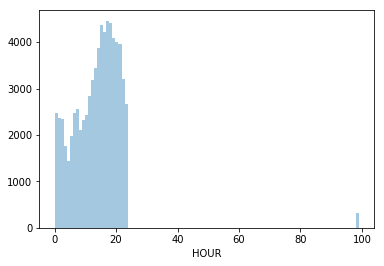

In [134]:
sns.distplot(df_master['HOUR'], kde=False, bins=100)

/Users/kellyjones/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


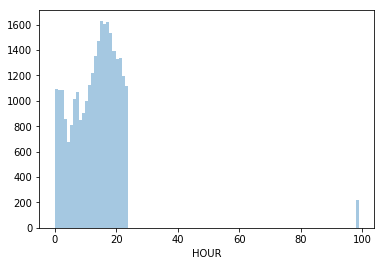

In [135]:
# Fatalities only
df_fatal = df_master[(df_master.INJ_SEV == 4)]
sns.distplot(df_fatal['HOUR'], kde=False, bins=100)

/Users/kellyjones/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


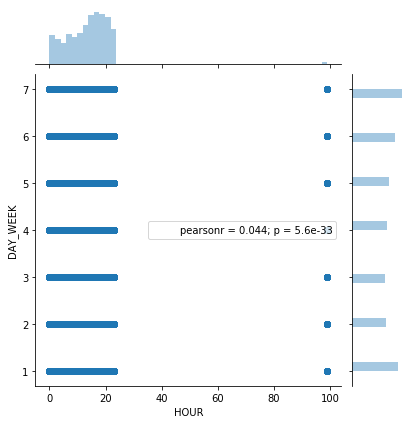

In [136]:
sns.jointplot(x='HOUR', y='DAY_WEEK', data=df_master)

In [137]:
df_master.groupby(['DAY_WEEK'])['ST_CASE'].count()
# way more incidents on Friday (6), Saturday (7), and Sunday (1)

DAY_WEEK
1    12021
2     8828
3     8776
4     9241
5     9860
6    11359
7    13174
Name: ST_CASE, dtype: int64

In [138]:
# want fatality count by day but only have person count
df_master.groupby(['DATE'])['ST_CASE'].count()

# This doesn't work:
# df_master['INJ_SEV' == 4].groupby(['DATE'])['ST_CASE'].count()

DATE
2015-01-01    207
2015-01-02    159
2015-01-03    211
2015-01-04    131
2015-01-05    190
2015-01-06    185
2015-01-07    141
2015-01-08    133
2015-01-09    357
2015-01-10    166
2015-01-11    157
2015-01-12    128
2015-01-13    174
2015-01-14    161
2015-01-15    133
2015-01-16    157
2015-01-17    163
2015-01-18    254
2015-01-19    134
2015-01-20    152
2015-01-21    140
2015-01-22    126
2015-01-23    193
2015-01-24    218
2015-01-25    178
2015-01-26    127
2015-01-27    130
2015-01-28    122
2015-01-29    124
2015-01-30    194
             ... 
2015-12-02    192
2015-12-03    231
2015-12-04    211
2015-12-05    254
2015-12-06    265
2015-12-07    158
2015-12-08    172
2015-12-09    160
2015-12-10    168
2015-12-11    240
2015-12-12    239
2015-12-13    248
2015-12-14    215
2015-12-15    186
2015-12-16    164
2015-12-17    201
2015-12-18    183
2015-12-19    264
2015-12-20    181
2015-12-21    166
2015-12-22    212
2015-12-23    312
2015-12-24    205
2015-12-25    224
2015-

## State

In [179]:
df_master.groupby(['STATE']).agg({'FATALS':sum})

,FATALS
STATE,
1,2020
2,167
4,2297
5,1371
6,7729
8,1367
9,626
10,278
11,45


## Misc Findings

**WARNING:** Don't ride on the exterior of a vehicle

In [265]:
# SEAT_POS = 55 (riding on vehicle exterior) was fatal 2/3 of the time
df_master.groupby(['SEAT_POS','FATALITY_TARGET'])['FATALITY_TARGET'].count().tail(6)

SEAT_POS  FATALITY_TARGET
55        0                   26
          1                   53
98        0                  154
          1                    8
99        0                  427
          1                  164
Name: FATALITY_TARGET, dtype: int64

**WARNING:** Do wear your seatbelt

In [269]:
# REST_USE = 7 (no seatbelt) was also fatal 2/3 of the time
df_master.groupby(['REST_USE','FATALITY_TARGET'])['FATALITY_TARGET'].count()

REST_USE  FATALITY_TARGET
0         0                    785
          1                    210
1         0                    126
          1                     65
2         0                    417
          1                    173
3         0                  30687
          1                  10190
4         0                    721
          1                     92
5         0                    155
          1                   1168
7         0                   5179
          1                  10042
8         0                    697
          1                    300
10        0                    491
          1                     45
11        0                    162
          1                     24
12        0                    194
          1                     44
16        0                     17
          1                    150
17        0                    369
          1                   2189
19        0                    197
          1                  

# Classification Models

## Create DataFrame for Modeling

### DataFrame 1 - Drop Some Columns

In [315]:
df_master.columns.values

array(['STATE', 'ST_CASE', 'VEH_NO', 'PER_NO', 'COUNTY', 'HARM_EV',
       'MAN_COLL', 'SCH_BUS', 'BODY_TYP', 'MOD_YEAR', 'TOW_VEH',
       'ROLLOVER', 'FIRE_EXP', 'AGE', 'SEX', 'PER_TYP', 'INJ_SEV',
       'SEAT_POS', 'REST_USE', 'REST_MIS', 'AIR_BAG', 'EJECTION',
       'EXTRICAT', 'DRINKING', 'DRUGS', 'HOSPITAL', 'DOA', 'STATE_ACC',
       'SCH_BUS_ACC', 'PEDS', 'PERSONS', 'CITY', 'DAY', 'MONTH', 'YEAR',
       'DAY_WEEK', 'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUD', 'LGT_COND',
       'WEATHER1', 'WEATHER2', 'WEATHER', 'NOT_HOUR', 'NOT_MIN',
       'ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2', 'CF3', 'FATALS', 'DRUNK_DR',
       'STATE_VEH', 'MAN_COLL_VEH', 'NUMOCCS', 'HIT_RUN', 'REG_STAT',
       'J_KNIFE', 'GVWR', 'HAZ_INV', 'BUS_USE', 'TRAV_SP', 'UNDERIDE',
       'IMPACT1', 'DEFORMED', 'TOWED', 'M_HARM', 'VEH_SC1', 'VEH_SC2',
       'L_STATE', 'DEATHS', 'DR_DRINK', 'DR_ZIP', 'L_STATUS', 'L_TYPE',
       'L_ENDORS', 'L_COMPL', 'DR_HGT', 'DR_WGT', 'PREV_ACC', 'PREV_SUS',
       'PREV_DWI', '

In [365]:
df_model = df_master.drop(['ST_CASE', 'VEH_NO', 'PER_NO', 'INJ_SEV', 'EXTRICAT', 'HOSPITAL', 
                           'DOA', 'STATE_ACC', 'SCH_BUS_ACC', 'DAY', 'MONTH', 'YEAR', 'MINUTE', 
                           'LATITUDE', 'LONGITUD', 'WEATHER1', 'WEATHER2', 'NOT_HOUR', 
                           'NOT_MIN','ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2', 'CF3', 'FATALS', 
                           'STATE_VEH', 'MAN_COLL_VEH', 'NUMOCCS', 'REG_STAT', 'GVWR', 'TRAV_SP',
                           'TOWED', 'VEH_SC2', 'L_STATE', 'DEATHS', 'DR_ZIP', 'DR_HGT', 'DR_WGT', 
                           'INJ_SEV_0', 'INJ_SEV_1', 'INJ_SEV_2', 'INJ_SEV_3', 'INJ_SEV_4', 'INJ_SEV_5', 
                           'INJ_SEV_6', 'INJ_SEV_9', 'DATE', 'DATE_TIME'], axis=1).set_index('UNIQ_ID')
# may want to drop 'PERSONS' as well

In [317]:
df_model.isnull().sum().sum() # still no nulls

0

In [318]:
df_model.head()

,STATE,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,DRINKING,DRUGS,PEDS,PERSONS,CITY,DAY_WEEK,HOUR,LGT_COND,WEATHER,DRUNK_DR,HIT_RUN,J_KNIFE,HAZ_INV,BUS_USE,UNDERIDE,IMPACT1,DEFORMED,M_HARM,VEH_SC1,VEH_SC2,DR_DRINK,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND,FATALITY_TARGET
UNIQ_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001_1_1,1,127,35,0,0,31,2003,0,0,0,68,1,1,11,7,0,1,0,9,9,0,1,0,5,2,2,1,1,0,0,1,0,0,12,6,42,0,0,1,6,1,0,3,1,0,0,1,0,0,0,0,0,0,2,55,1,1,1
10002_1_1,1,83,34,0,0,4,2006,0,1,0,49,1,1,11,7,0,20,1,0,0,0,1,0,5,22,2,10,0,0,0,1,0,0,6,6,1,0,0,0,6,1,0,3,2,2,0,0,0,4,89,0,0,0,2,70,1,2,1
10003_1_1,1,11,42,0,0,4,2008,0,1,1,31,1,1,11,7,0,1,0,1,9,0,2,0,5,1,2,1,1,0,0,1,0,0,12,6,42,0,0,1,6,1,0,3,2,0,0,1,0,0,0,0,0,0,2,55,1,1,1
10003_1_2,1,11,42,0,0,4,2008,0,1,1,20,2,2,13,7,0,1,0,8,8,0,2,0,5,1,2,1,1,0,0,1,0,0,12,6,42,0,0,1,6,1,0,3,2,0,0,1,0,0,0,0,0,0,2,55,1,1,0
10004_1_1,1,45,53,0,0,31,2005,0,0,0,40,1,1,11,7,0,20,0,1,9,0,1,0,1,0,2,10,1,0,0,1,0,0,12,6,42,0,0,1,6,1,0,3,0,0,0,0,0,0,0,0,0,0,2,55,1,1,1


In [319]:
df_model.columns

Index(['STATE', 'COUNTY', 'HARM_EV', 'MAN_COLL', 'SCH_BUS', 'BODY_TYP',
       'MOD_YEAR', 'TOW_VEH', 'ROLLOVER', 'FIRE_EXP', 'AGE', 'SEX', 'PER_TYP',
       'SEAT_POS', 'REST_USE', 'REST_MIS', 'AIR_BAG', 'EJECTION', 'DRINKING',
       'DRUGS', 'PEDS', 'PERSONS', 'CITY', 'DAY_WEEK', 'HOUR', 'LGT_COND',
       'WEATHER', 'DRUNK_DR', 'HIT_RUN', 'J_KNIFE', 'HAZ_INV', 'BUS_USE',
       'UNDERIDE', 'IMPACT1', 'DEFORMED', 'M_HARM', 'VEH_SC1', 'VEH_SC2',
       'DR_DRINK', 'L_STATUS', 'L_TYPE', 'L_ENDORS', 'L_COMPL', 'PREV_ACC',
       'PREV_SUS', 'PREV_DWI', 'PREV_SPD', 'PREV_OTH', 'SPEEDREL', 'DR_SF1',
       'DR_SF2', 'DR_SF3', 'DR_SF4', 'VNUM_LAN', 'VSPD_LIM', 'VPROFILE',
       'VSURCOND', 'FATALITY_TARGET'],
      dtype='object')

### DataFrame 2 - Drop "Unknown" Values

In [320]:
df_model2 = df_model.copy()

In [321]:
df_model2.shape

(73259, 58)

In [322]:
# COUNTY
df_model2.groupby(['COUNTY'])['COUNTY'].count() # N=1 to drop, value=999
df_model2['COUNTY'].replace(to_replace=999, value=np.nan, inplace=True)
df_model2['COUNTY'].describe()

count    73258.000000
mean        92.201998
std         94.804933
min          1.000000
25%         31.000000
50%         71.000000
75%        115.000000
max        840.000000
Name: COUNTY, dtype: float64

In [323]:
# HARM_EV First Harmful Event
df_model2.groupby(['HARM_EV'])['HARM_EV'].count() # N=24 to drop, value=99
df_model2['HARM_EV'].replace(to_replace=99, value=np.nan, inplace=True)
df_model2['HARM_EV'].describe()

count    73235.000000
mean        16.133379
std         12.048076
min          1.000000
25%         12.000000
50%         12.000000
75%         12.000000
max         73.000000
Name: HARM_EV, dtype: float64

In [324]:
# MAN_COLL Manner of Collision
df_model2.groupby(['MAN_COLL'])['MAN_COLL'].count() # N=57 and 159 to drop, value=98 and 99
df_model2['MAN_COLL'].replace(to_replace=(98,99), value=np.nan, inplace=True)
df_model2['MAN_COLL'].describe()

count    73043.000000
mean         2.347220
std          2.751438
min          0.000000
25%          0.000000
50%          1.000000
75%          6.000000
max         11.000000
Name: MAN_COLL, dtype: float64

In [325]:
# SCH_BUS School Bus Related
df_model2.groupby(['SCH_BUS'])['SCH_BUS'].count() # no nulls

SCH_BUS
0    72706
1      553
Name: SCH_BUS, dtype: int64

In [326]:
# BODY_TYP Body type of vehicle
df_model2.groupby(['BODY_TYP'])['BODY_TYP'].count() # N=4 and 771 to drop, value=98 and 99
df_model2['BODY_TYP'].replace(to_replace=(98,99), value=np.nan, inplace=True)
df_model2['BODY_TYP'].describe()

count    72484.000000
mean        23.068953
std         24.557485
min          1.000000
25%          4.000000
50%         14.000000
75%         31.000000
max         97.000000
Name: BODY_TYP, dtype: float64

In [327]:
# MOD_YEAR Model year of vehicle
df_model2.groupby(['MOD_YEAR'])['MOD_YEAR'].count() # N=4 and 1290 to drop, value=9998 and 9999
df_model2['MOD_YEAR'].replace(to_replace=(9998,9999), value=np.nan, inplace=True)
df_model2['MOD_YEAR'].describe()

count    71965.000000
mean      2004.787480
std          6.935089
min       1923.000000
25%       2001.000000
50%       2005.000000
75%       2010.000000
max       2016.000000
Name: MOD_YEAR, dtype: float64

In [328]:
# TOW_VEH If vehicle had attached trailing units (horse trailer, boat, other vehicle)
df_model2.groupby(['TOW_VEH'])['TOW_VEH'].count() # N=128 to drop, value=9
df_model2['TOW_VEH'].replace(to_replace=(9), value=np.nan, inplace=True)
df_model2['TOW_VEH'].describe()

count    73131.000000
mean         0.064008
std          0.308842
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          6.000000
Name: TOW_VEH, dtype: float64

In [329]:
# ROLLOVER If vehicle rolled over during crash
df_model2.groupby(['ROLLOVER'])['ROLLOVER'].count() # no true unknowns; 9 is rollover of unknown type

ROLLOVER
0    59504
1    11361
2     1822
9      572
Name: ROLLOVER, dtype: int64

In [330]:
# FIRE_EXP If fire in any way related to crash in this vehicle
df_model2.groupby(['FIRE_EXP'])['FIRE_EXP'].count() # no nulls - 0 is no or not reported

FIRE_EXP
0    70948
1     2311
Name: FIRE_EXP, dtype: int64

In [331]:
# AGE
df_model2.groupby(['AGE'])['AGE'].count() # N=550 and 1011 to drop, value=998 and 999
df_model2['AGE'].replace(to_replace=(998,999), value=np.nan, inplace=True)
df_model2['AGE'].describe()

count    71698.000000
mean        38.529415
std         20.243503
min          0.000000
25%         22.000000
50%         35.000000
75%         53.000000
max        114.000000
Name: AGE, dtype: float64

In [332]:
# SEX
df_model2.groupby(['SEX'])['SEX'].count() # N=379 and 942 to drop, value=8 and 9
df_model2['SEX'].replace(to_replace=(8,9), value=np.nan, inplace=True)
df_model2['SEX'].describe()

count    71938.000000
mean         1.340960
std          0.474035
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: SEX, dtype: float64

In [333]:
# PER_TYP Driver or passenger
df_model2.groupby(['PER_TYP'])['PER_TYP'].count() # No nulls - already filtered on this

PER_TYP
1    48613
2    24646
Name: PER_TYP, dtype: int64

In [334]:
# SEAT_POS Location of seat in vehicle
df_model2.groupby(['SEAT_POS'])['SEAT_POS'].count() # N=162 and 591 to drop, value=98 and 99
df_model2['SEAT_POS'].replace(to_replace=(98,99), value=np.nan, inplace=True)
df_model2['SEAT_POS'].describe()

count    72506.000000
mean        13.723278
std          6.661827
min         11.000000
25%         11.000000
50%         11.000000
75%         13.000000
max         55.000000
Name: SEAT_POS, dtype: float64

In [335]:
# REST_USE What kind of restraint (e.g., seatbelt) used, 7=none
df_model2.groupby(['REST_USE'])['REST_USE'].count() # N=797 and 5744 to drop, value=98 and 99
df_model2['REST_USE'].replace(to_replace=(98,99), value=np.nan, inplace=True)
df_model2['REST_USE'].describe()

count    66718.000000
mean         5.244132
std          5.042749
min          0.000000
25%          3.000000
50%          3.000000
75%          7.000000
max         97.000000
Name: REST_USE, dtype: float64

In [336]:
# REST_MIS Misuse of restraint system
df_model2.groupby(['REST_MIS'])['REST_MIS'].count() # no nulls

REST_MIS
0    73037
1      222
Name: REST_MIS, dtype: int64

In [337]:
# AIR_BAG Air bag availability and deployment for person's seat
df_model2.groupby(['AIR_BAG'])['AIR_BAG'].count() # N=919 and 2860 to drop, value=98 and 99
df_model2['AIR_BAG'].replace(to_replace=(98,99), value=np.nan, inplace=True)
df_model2['AIR_BAG'].describe()

count    69480.000000
mean         8.409211
std          8.948900
min          0.000000
25%          0.000000
50%          2.000000
75%         20.000000
max         28.000000
Name: AIR_BAG, dtype: float64

In [338]:
# EJECTION Ejection status and degree of ejection, not counting motorcycle occupants
# Recoded 8 ('not applicable') as 0 ('not ejected') - think those were motorcyclists
df_model2.groupby(['EJECTION'])['EJECTION'].count() # N=317 to drop, value=9
df_model2['EJECTION'].replace(to_replace=9, value=np.nan, inplace=True)
df_model2['EJECTION'].replace(to_replace=8, value=0, inplace=True)
df_model2['EJECTION'].describe()

count    72942.000000
mean         0.141153
std          0.572689
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: EJECTION, dtype: float64

In [339]:
# DRINKING Whether alcohol was involved for THIS person
# 0 is no, 1 is yes
# Would lose half the dataset by dropping not reported/unknowns, so...
# Recode not reported (8) and unknown (9) as new category "unlikely" (0.2)
# May drop whole feature later
df_model2['DRINKING'].replace(to_replace=(8,9), value=0.2, inplace=True)
df_model2.groupby(['DRINKING'])['DRINKING'].count()

DRINKING
0.0    30910
0.2    35654
1.0     6695
Name: DRINKING, dtype: int64

In [340]:
# DRUGS Whether drugs were involved for THIS person
# 0 is no, 1 is yes
# Would lose half the dataset by dropping not reported/unknowns, so...
# Recode not reported (8) and unknown (9) as new category "unlikely" (0.2)
# May drop whole feature later
df_model2['DRUGS'].replace(to_replace=(8,9), value=0.2, inplace=True)
df_model2.groupby(['DRUGS'])['DRUGS'].count()

DRUGS
0.0    29712
0.2    40530
1.0     3017
Name: DRUGS, dtype: int64

In [341]:
# PEDS Number of pedestrians - forms submitted for persons NOT IN motor vehicle
df_model2.groupby(['PEDS'])['PEDS'].count() # no nulls

PEDS
0     64001
1      8596
2       468
3        95
4        60
5        12
6         9
7         4
9        11
11        2
16        1
Name: PEDS, dtype: int64

In [342]:
# PERSONS Number of occupants - forms submitted for persons IN motor vehicle
df_model2.groupby(['PERSONS'])['PERSONS'].count() # no nulls

PERSONS
1     13302
2     17511
3     14080
4      9367
5      6450
6      4282
7      2587
8      1770
9       795
10      635
11      535
12      389
13      234
14      181
15      117
16       64
17       34
18      126
19       38
20       20
22       22
23       23
24       96
27       79
28       28
29       29
32       32
35       35
37       37
48       48
49       49
50       50
53       53
68       68
93       93
Name: PERSONS, dtype: int64

In [343]:
# CITY
df_model2.groupby(['CITY'])['CITY'].count() # N=28 and 12 to drop, value=9898 and 9999
df_model2['CITY'].replace(to_replace=(9898,9999), value=np.nan, inplace=True)
df_model2['CITY'].describe()

count    73219.000000
mean      1168.018834
std       1859.333221
min          0.000000
25%          0.000000
50%          0.000000
75%       1900.000000
max       9997.000000
Name: CITY, dtype: float64

In [344]:
# DAY_WEEK Sunday is 1
df_model2.groupby(['DAY_WEEK'])['DAY_WEEK'].count() # no nulls

DAY_WEEK
1    12021
2     8828
3     8776
4     9241
5     9860
6    11359
7    13174
Name: DAY_WEEK, dtype: int64

In [345]:
# HOUR Hour of day from 0 to 23
df_model2.groupby(['HOUR'])['HOUR'].count() # N=312 to drop, value=99
df_model2['HOUR'] = df_model2['HOUR'].replace(to_replace=99, value=np.nan)
df_model2['HOUR'].describe()

# len(df_model2[(df_model2['HOUR'] >= 0) & (df_model2['HOUR'] <= 24)]) # IDEA FROM PETER - also works
# Drawback of mine: adding NaN changes type to float (numpy can't do otherwise)
# Will have to change back to int later

count    72947.000000
mean        13.047500
std          6.584352
min          0.000000
25%          8.000000
50%         14.000000
75%         18.000000
max         23.000000
Name: HOUR, dtype: float64

In [346]:
# LGT_COND Level of light at time of crash; 1 is daylight, 2 is dark
df_model2.groupby(['LGT_COND'])['LGT_COND'].count() # N=32 and 175 to drop, value=8 and 9
df_model2['LGT_COND'].replace(to_replace=(8,9), value=np.nan, inplace=True)
df_model2['LGT_COND'].describe()

count    73052.000000
mean         1.781895
std          1.028698
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          7.000000
Name: LGT_COND, dtype: float64

In [347]:
# WEATHER
df_model2.groupby(['WEATHER'])['WEATHER'].count() # N=164 and 414 to drop, value=98 and 99
df_model2['WEATHER'].replace(to_replace=(98,99), value=np.nan, inplace=True)
df_model2['WEATHER'].describe()

count    72681.000000
mean         2.716969
std          3.362650
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         12.000000
Name: WEATHER, dtype: float64

In [348]:
# DRUNK_DR Number of drunk drivers involved in the crash
df_model2.groupby(['DRUNK_DR'])['DRUNK_DR'].count() # no nulls

DRUNK_DR
0    54495
1    17931
2      823
3       10
Name: DRUNK_DR, dtype: int64

In [349]:
# HIT_RUN Whether this vehicle was a hit-and-run (did not stop to help)
df_model2.groupby(['HIT_RUN'])['HIT_RUN'].count() # N=38 to drop, value=9
df_model2['HIT_RUN'].replace(to_replace=9, value=np.nan, inplace=True)
df_model2['HIT_RUN'].describe()

count    73221.000000
mean         0.030237
std          0.171241
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: HIT_RUN, dtype: float64

In [350]:
# J_KNIFE Did vehicle jackknife - 0 n/a (not a truck), 1 no, 
# 2 yes in first event, 3 yes in subsequent event
df_model2.groupby(['J_KNIFE'])['J_KNIFE'].count() # no nulls

J_KNIFE
0    69144
1     3774
2       93
3      248
Name: J_KNIFE, dtype: int64

In [351]:
# HAZ_INV Was this vehicle carrying hazardous materials
df_model2.groupby(['HAZ_INV'])['HAZ_INV'].count() # no nulls

HAZ_INV
1    73117
2      142
Name: HAZ_INV, dtype: int64

In [352]:
# BUS_USE Type of bus - 0 not bus, 1 school bus, others
df_model2.groupby(['BUS_USE'])['BUS_USE'].count() # N=78 and 160 to drop, value=98 and 99
df_model2['BUS_USE'].replace(to_replace=(98,99), value=np.nan, inplace=True)
df_model2['BUS_USE'].describe()

count    73021.000000
mean         0.046822
std          0.496039
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: BUS_USE, dtype: float64

In [355]:
# UNDERIDE Vehicle's invovlement in underride/override; v. dangerous kind of accident
df_model2.groupby(['UNDERIDE'])['UNDERIDE'].count() # N=115 to drop, value=9
df_model2['UNDERIDE'].replace(to_replace=9, value=np.nan, inplace=True)
df_model2['UNDERIDE'].describe()

count    73144.000000
mean         0.027562
std          0.369947
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: UNDERIDE, dtype: float64

In [357]:
# IMPACT1 Initial contact point; very strange scale
# Consider dropping this or recategorizing
df_model2.groupby(['IMPACT1'])['IMPACT1'].count() # N=1879 and 894 to drop, value=98 and 99
df_model2['IMPACT1'].replace(to_replace=(98,99), value=np.nan, inplace=True)
df_model2['IMPACT1'].describe()

count    70486.000000
mean        14.209673
std         17.556283
min          0.000000
25%          7.000000
50%         12.000000
75%         12.000000
max         83.000000
Name: IMPACT1, dtype: float64

In [359]:
# DEFORMED Damage: none, minor, functional, disabling (2,4,6,8)
df_model2.groupby(['DEFORMED'])['DEFORMED'].count() # N=4162 and 1348 to drop, value=8 and 9
df_model2['DEFORMED'].replace(to_replace=(8,9), value=np.nan, inplace=True)
df_model2['DEFORMED'].describe()

count    67749.000000
mean         5.402412
std          1.361298
min          0.000000
25%          6.000000
50%          6.000000
75%          6.000000
max          6.000000
Name: DEFORMED, dtype: float64

In [361]:
# M_HARM Most Harmful Event - long list of options, incl pedestrian (8)
df_model2.groupby(['M_HARM'])['M_HARM'].count() # N=62 to drop, value=99
df_model2['M_HARM'].replace(to_replace=99, value=np.nan, inplace=True)
df_model2['M_HARM'].describe()

count    73197.000000
mean        14.173136
std         11.728171
min          1.000000
25%          9.000000
50%         12.000000
75%         12.000000
max         73.000000
Name: M_HARM, dtype: float64

In [364]:
# VEH_SC1 Related vehicle factor 1
df_model2.groupby(['VEH_SC1'])['VEH_SC1'].count() # N=330 to drop, value=99
df_model2['VEH_SC1'].replace(to_replace=99, value=np.nan, inplace=True)
df_model2['VEH_SC1'].describe()

count    72929.000000
mean         0.350464
std          3.502290
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         44.000000
Name: VEH_SC1, dtype: float64

In [363]:
# VEH_SC2 Related vehicle factor 2
df_model2.groupby(['VEH_SC2'])['VEH_SC2'].count() # N=x to drop, value=x
# df_model2['VEH_SC2'].replace(to_replace=(x), value=np.nan, inplace=True)
# df_model2['VEH_SC2'].describe()

VEH_SC2
0     72928
44        1
99      330
Name: VEH_SC2, dtype: int64

In [367]:
# DR_DRINK Whether driver of the vehicle was drinking
df_model2.groupby(['DR_DRINK'])['DR_DRINK'].count() # no nulls

DR_DRINK
0    60124
1    13135
Name: DR_DRINK, dtype: int64

In [369]:
# L_STATUS Status of driver's license (per vehicle) - may want to rebucket pos & neg
df_model2.groupby(['L_STATUS'])['L_STATUS'].count() # N=1843 to drop, value=9
df_model2['L_STATUS'].replace(to_replace=9, value=np.nan, inplace=True)
df_model2['L_STATUS'].describe()

count    71416.000000
mean         5.299037
std          1.798378
min          0.000000
25%          6.000000
50%          6.000000
75%          6.000000
max          7.000000
Name: L_STATUS, dtype: float64

In [373]:
# L_TYPE desc
df_model2.groupby(['L_TYPE'])['L_TYPE'].count() # N=1835 to drop, value=9
df_model2['L_TYPE'].replace(to_replace=9, value=np.nan, inplace=True)
df_model2['L_TYPE'].describe()

count    71424.000000
mean         1.018943
std          0.626742
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: L_TYPE, dtype: float64

In [374]:
# L_ENDORS Commercial endorsement compliance - another pos/neg rebucket needed
df_model2.groupby(['L_ENDORS'])['L_ENDORS'].count() # N=1835 to drop, value=9
df_model2['L_ENDORS'].replace(to_replace=9, value=np.nan, inplace=True)
df_model2['L_ENDORS'].describe()

count    71424.000000
mean         0.049997
std          0.367202
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: L_ENDORS, dtype: float64

In [375]:
# L_COMPL Compliance with license requirement - prob need pos/neg
df_model2.groupby(['L_COMPL'])['L_COMPL'].count() # N=24 and 1913 to drop, value=8 and 9
df_model2['L_COMPL'].replace(to_replace=(8,9), value=np.nan, inplace=True)
df_model2['L_COMPL'].describe()

count    71322.000000
mean         2.736112
std          0.735581
min          0.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          6.000000
Name: L_COMPL, dtype: float64

In [377]:
# PREV_ACC Driver's number of previous accidents in last 5 yrs
# 98 (not reported on driving record) and 998 (no driver present/unknown) recoded 0
# 99 (unknown) dropped
df_model2.groupby(['PREV_ACC'])['PREV_ACC'].count() # N=2480 to drop, value=99
df_model2['PREV_ACC'].replace(to_replace=99, value=np.nan, inplace=True)
df_model2['PREV_ACC'].replace(to_replace=(98,998), value=0, inplace=True)
df_model2['PREV_ACC'].describe()

count    70779.000000
mean         0.201373
std          0.544455
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: PREV_ACC, dtype: float64

In [383]:
# PREV_SUS Driver's number of previous suspensions/revocations of license in last 5 yrs
# 99 to null, 998 to 0
df_model2.groupby(['PREV_SUS'])['PREV_SUS'].count() # N=2485 to drop, value=99
df_model2['PREV_SUS'].replace(to_replace=99, value=np.nan, inplace=True)
df_model2['PREV_SUS'].replace(to_replace=998, value=0, inplace=True)
df_model2['PREV_SUS'].describe()

count    70774.000000
mean         0.447848
std          1.917236
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         78.000000
Name: PREV_SUS, dtype: float64

In [384]:
# PREV_DWI Driver's number of previous DWI convictions in last 5 yrs
# 99 to null, 998 to 0
df_model2.groupby(['PREV_DWI'])['PREV_DWI'].count() # N=2485 to drop, value=99
df_model2['PREV_DWI'].replace(to_replace=99, value=np.nan, inplace=True)
df_model2['PREV_DWI'].replace(to_replace=998, value=0, inplace=True)
df_model2['PREV_DWI'].describe()

count    70774.000000
mean         0.041837
std          0.241543
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          6.000000
Name: PREV_DWI, dtype: float64

In [386]:
# PREV_SPD Driver's number of previous speeding convictions in last 5 yrs
# 99 to null, 998 to 0
df_model2.groupby(['PREV_SPD'])['PREV_SPD'].count() # N=2485 to drop, value=99
df_model2['PREV_SPD'].replace(to_replace=99, value=np.nan, inplace=True)
df_model2['PREV_SPD'].replace(to_replace=998, value=0, inplace=True)
df_model2['PREV_SPD'].describe()

count    70774.000000
mean         0.306412
std          0.752664
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: PREV_SPD, dtype: float64

In [387]:
# PREV_OTH Driver's number of other previous convictions in last 5 yrs
# 99 to null, 998 to 0
df_model2.groupby(['PREV_OTH'])['PREV_OTH'].count() # N=x to drop, value=99
df_model2['PREV_OTH'].replace(to_replace=99, value=np.nan, inplace=True)
df_model2['PREV_OTH'].replace(to_replace=998, value=0, inplace=True)
df_model2['PREV_OTH'].describe()

count    70774.000000
mean         0.365883
std          1.025486
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         37.000000
Name: PREV_OTH, dtype: float64

In [388]:
# SPEEDREL desc
# 8 to 0, 9 to null
df_model2.groupby(['SPEEDREL'])['SPEEDREL'].count() # N=2905 to drop, value=9
df_model2['SPEEDREL'].replace(to_replace=9, value=np.nan, inplace=True)
df_model2['SPEEDREL'].replace(to_replace=8, value=0, inplace=True)
df_model2['SPEEDREL'].describe()

count    70354.000000
mean         0.705774
std          1.490958
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: SPEEDREL, dtype: float64

In [398]:
# DR_SF1 Driver-level related factors (drowsiness, distraction, going wrong way, etc.)
# May need to bucket across four DR_SF variables
df_model2.groupby(['DR_SF1'])['DR_SF1'].count() # N=3070 to drop, value=99
df_model2['DR_SF1'].replace(to_replace=99, value=np.nan, inplace=True)
df_model2['DR_SF1'].describe()

count    70189.000000
mean        16.293009
std         24.141027
min          0.000000
25%          0.000000
50%          0.000000
75%         36.000000
max         91.000000
Name: DR_SF1, dtype: float64

In [399]:
# DR_SF2 see above
df_model2.groupby(['DR_SF2'])['DR_SF2'].count() # N=3070 to drop, value=99
df_model2['DR_SF2'].replace(to_replace=99, value=np.nan, inplace=True)
df_model2['DR_SF2'].describe()

count    70189.000000
mean         4.305518
std         15.403185
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         91.000000
Name: DR_SF2, dtype: float64

In [400]:
# DR_SF3 see above
df_model2.groupby(['DR_SF3'])['DR_SF3'].count() # N=3070 to drop, value=99
df_model2['DR_SF3'].replace(to_replace=99, value=np.nan, inplace=True)
df_model2['DR_SF3'].describe()

count    70189.000000
mean         0.911154
std          7.573074
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         91.000000
Name: DR_SF3, dtype: float64

In [401]:
# DR_SF4 see above
df_model2.groupby(['DR_SF4'])['DR_SF4'].count() # N=3070 to drop, value=99
df_model2['DR_SF4'].replace(to_replace=99, value=np.nan, inplace=True)
df_model2['DR_SF4'].describe()

count    70189.000000
mean         0.187380
std          3.602257
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         91.000000
Name: DR_SF4, dtype: float64

In [403]:
# VNUM_LAN Total lanes in roadway; 8 not reported, 9 unknown
df_model2.groupby(['VNUM_LAN'])['VNUM_LAN'].count() # N=278 and 174 to drop, value=8 and 9
df_model2['VNUM_LAN'].replace(to_replace=(8,9), value=np.nan, inplace=True)
df_model2['VNUM_LAN'].describe()

count    72807.000000
mean         2.575783
std          1.101288
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: VNUM_LAN, dtype: float64

In [404]:
# VSPD_LIM Speed limit in 5 mph increments; 0 if driveway or no statutory limit
df_model2.groupby(['VSPD_LIM'])['VSPD_LIM'].count() # N=2163 and 846 to drop, value=98 and 99
df_model2['VSPD_LIM'].replace(to_replace=(98,99), value=np.nan, inplace=True)
df_model2['VSPD_LIM'].describe()

count    70250.000000
mean        50.202562
std         13.719589
min          0.000000
25%         40.000000
50%         55.000000
75%         60.000000
max         85.000000
Name: VSPD_LIM, dtype: float64

In [405]:
# VPROFILE Roadway Grade (level, hill, etc) for vehicle; should be categorical
df_model2.groupby(['VPROFILE'])['VPROFILE'].count() # N=4632 and 395 to drop, value=8 and 9
df_model2['VPROFILE'].replace(to_replace=(8,9), value=np.nan, inplace=True)
df_model2['VPROFILE'].describe()

count    68232.000000
mean         1.663545
std          1.446576
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: VPROFILE, dtype: float64

In [406]:
# VSURCOND Roadway surface condition prior to vehicle's crash; 1 is dry; should be cat
df_model2.groupby(['VSURCOND'])['VSURCOND'].count() # N=463 and 364 to drop, value=98 and 99
df_model2['VSURCOND'].replace(to_replace=(98,99), value=np.nan, inplace=True)
df_model2['VSURCOND'].describe()

count    72432.000000
mean         1.244947
std          0.871990
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: VSURCOND, dtype: float64

In [407]:
df_model2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73259 entries, 10001_1_1 to 560130_1_1
Data columns (total 58 columns):
STATE              73259 non-null int64
COUNTY             73258 non-null float64
HARM_EV            73235 non-null float64
MAN_COLL           73043 non-null float64
SCH_BUS            73259 non-null int64
BODY_TYP           72484 non-null float64
MOD_YEAR           71965 non-null float64
TOW_VEH            73131 non-null float64
ROLLOVER           73259 non-null int64
FIRE_EXP           73259 non-null int64
AGE                71698 non-null float64
SEX                71938 non-null float64
PER_TYP            73259 non-null int64
SEAT_POS           72506 non-null float64
REST_USE           66718 non-null float64
REST_MIS           73259 non-null int64
AIR_BAG            69480 non-null float64
EJECTION           72942 non-null float64
DRINKING           73259 non-null float64
DRUGS              73259 non-null float64
PEDS               73259 non-null int64
PERSONS        

In [408]:
df_model2.dropna(axis=0, how='any', inplace=True)
df_model2.shape # was (73259, 59) - now (49938, 58)

(49938, 58)

#### Tricky Case!!!

In [313]:
# TRAV_SP: Speed vehicle was traveling before crash
# 997 is >150 so could recode to 155
# Not sure what to do with this! Just drop whole var?
df_model2.groupby(['TRAV_SP'])['TRAV_SP'].count() # N=37,512 and 6,617 to drop, value=998 and 999
# df_model2['TRAV_SP'].replace(to_replace=(x), value=np.nan, inplace=True)
# df_model2['TRAV_SP'].describe()

TRAV_SP
0       3123
1         36
2         36
3         34
4         13
5        632
6         20
7         30
8         41
9         11
10       826
11        25
12        26
13        26
14        25
15       706
16        17
17        26
18        34
19        15
20       516
21        16
22        29
23        31
24        18
25       616
26        13
27        20
28        51
29        14
       ...  
104        8
105       17
106       12
107        8
108        3
109        6
110       24
111        3
112       15
113        6
114        5
115       13
116        5
118        5
119        9
120       22
122        1
123        2
124        7
125        1
126        4
128        2
130        7
134        1
137        1
140        3
150        2
997        1
998    37512
999     6617
Name: TRAV_SP, Length: 134, dtype: int64

### DataFrame 3 - And Create True Categoricals

**States**

In [182]:
df_model3 = df_model.copy()
# Could also take from model2 here if we end up using nulls

In [183]:
# SOURCE: This cell from Mike Chirico on Kaggle 
# https://www.kaggle.com/mchirico/traffic-fatalities-getting-started

states = {1: 'Alabama', 2: 'Alaska', 4: 'Arizona', 5: 'Arkansas', 
          6: 'California', 8: 'Colorado', 9: 'Connecticut', 10: 'Delaware', 
          11: 'District of Columbia', 12: 'Florida', 13: 'Georgia', 15: 'Hawaii', 
          16: 'Idaho', 17: 'Illinois', 18: 'Indiana', 19: 'Iowa', 20: 'Kansas', 
          21: 'Kentucky', 22: 'Louisiana', 23: 'Maine', 24: 'Maryland', 
          25: 'Massachusetts', 26: 'Michigan', 27: 'Minnesota', 
          28: 'Mississippi', 29: 'Missouri', 30: 'Montana', 31: 'Nebraska', 
          32: 'Nevada', 33: 'New Hampshire', 34: 'New Jersey', 35: 'New Mexico', 
          36: 'New York', 37: 'North Carolina', 38: 'North Dakota', 39: 'Ohio', 
          40: 'Oklahoma', 41: 'Oregon', 42: 'Pennsylvania', 43: 'Puerto Rico', 
          44: 'Rhode Island', 45: 'South Carolina', 46: 'South Dakota', 47: 'Tennessee', 
          48: 'Texas', 49: 'Utah', 50: 'Vermont', 51: 'Virginia', 52: 'Virgin Islands', 
          53: 'Washington', 54: 'West Virginia', 55: 'Wisconsin', 56: 'Wyoming'}

df_model3['STATE'] = df_model3['STATE'].apply(lambda x: states[x])
df_model3['STATE'].value_counts().to_frame() 

,STATE
Texas,7550
California,6624
Florida,6171
Georgia,3055
North Carolina,2895
Pennsylvania,2463
Ohio,2320
New York,2266
Michigan,2112
South Carolina,2101


In [184]:
df_model3.sample()

,STATE,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,DRINKING,DRUGS,PEDS,PERSONS,CITY,DAY_WEEK,HOUR,LGT_COND,WEATHER,DRUNK_DR,HIT_RUN,J_KNIFE,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,M_HARM,VEH_SC1,VEH_SC2,DR_DRINK,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND,FATALITY_TARGET
UNIQ_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
470127_2_3,Tennessee,157,12,6,0,4,2001,0,0,0,21,2,2,22,7,0,0,0,0,0,0,5,1620,3,22,3,1,1,0,0,1,0,998,0,3,6,12,0,0,0,1,1,0,2,0,1,0,0,0,0,0,0,0,0,7,40,1,1,0


**WEATHER**

In [194]:
# SOURCE: This cell from Mike Chirico on Kaggle 
# https://www.kaggle.com/mchirico/traffic-fatalities-getting-started

weather = {0: 'No Additional Atmospheric Conditions', 1: 'Clear', 
           2: 'Rain', 3: 'Sleet, Hail', 
           4: 'Snow', 5: 'Fog, Smog, Smoke', 6: 'Severe Crosswinds', 
           7: 'Blowing Sand, Soil, Dirt', 
           8: 'Other', 10: 'Cloudy', 11: 'Blowing Snow', 
           12: 'Freezing Rain or Drizzle', 
           98: 'Not Reported', 99: 'Unknown'}

df_model3['WEATHER'] = df_model3['WEATHER'].apply(lambda x: weather[x])
# d['weather1']=d['WEATHER1'].apply(lambda x: weather[x])
# d['weather2']=d['WEATHER2'].apply(lambda x: weather[x])

In [198]:
df_model3.groupby(['WEATHER'])['STATE'].describe()

,count,unique,top,freq
WEATHER,,,,
"Blowing Sand, Soil, Dirt",122,10,Ohio,28
Blowing Snow,161,14,Ohio,99
Clear,52295,50,California,5627
Cloudy,11969,48,Texas,1399
"Fog, Smog, Smoke",922,45,Texas,107
Freezing Rain or Drizzle,76,13,Kansas,17
Not Reported,164,21,Oregon,72
Other,112,14,Missouri,32
Rain,5733,51,Texas,669


## Train/Test Split

In [73]:
# create X (features) and y (response)
X = df_model.drop('FATALITY_TARGET', axis=1)
y = df_model['FATALITY_TARGET']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
X.sample(5)

,STATE,COUNTY,HARM_EV,MAN_COLL,SCH_BUS,BODY_TYP,MOD_YEAR,TOW_VEH,ROLLOVER,FIRE_EXP,AGE,SEX,PER_TYP,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,DRINKING,DRUGS,PEDS,CITY,DAY_WEEK,HOUR,LGT_COND,WEATHER,DRUNK_DR,HIT_RUN,J_KNIFE,HAZ_INV,BUS_USE,TRAV_SP,UNDERIDE,IMPACT1,DEFORMED,M_HARM,VEH_SC1,VEH_SC2,DR_DRINK,L_STATUS,L_TYPE,L_ENDORS,L_COMPL,PREV_ACC,PREV_SUS,PREV_DWI,PREV_SPD,PREV_OTH,SPEEDREL,DR_SF1,DR_SF2,DR_SF3,DR_SF4,VNUM_LAN,VSPD_LIM,VPROFILE,VSURCOND
UNIQ_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
540193_1_2,54,81,1,0,0,14,2013,0,1,0,20,2,2,13,7,0,1,0,8,8,0,1022,2,9,1,1,0,0,0,1,0,998,0,0,6,1,0,0,0,6,1,0,3,0,0,0,0,0,3,0,0,0,0,2,35,1,1
560004_1_2,56,29,1,0,0,31,2006,0,1,0,17,1,2,23,7,0,0,0,8,8,0,0,5,2,2,1,0,0,0,1,0,50,0,0,6,1,0,0,0,3,2,0,2,0,0,0,0,0,4,58,87,0,0,2,45,3,4
220250_2_2,22,97,12,6,0,80,2011,0,0,0,38,2,2,21,16,0,0,8,8,8,0,0,5,21,6,1,0,0,0,1,0,65,0,3,6,1,0,0,0,6,1,0,3,0,0,0,0,0,0,0,0,0,0,2,65,1,1
121155_2_1,12,86,12,7,0,88,2014,0,0,0,52,1,1,11,5,0,0,8,0,0,0,0,2,5,3,1,0,0,0,1,0,50,0,10,6,12,0,0,0,9,9,9,9,99,99,99,99,99,0,0,0,0,0,6,55,1,1
280479_1_22,28,77,12,6,1,50,2014,0,0,0,9,2,2,51,0,0,0,0,8,8,0,0,2,15,1,1,0,0,0,1,1,35,0,12,2,12,0,0,0,6,1,0,3,98,0,0,0,0,0,0,0,0,0,2,55,1,2


In [76]:
y.sample(10)

UNIQ_ID
530008_1_2    1
290066_2_1    0
360607_1_1    1
121810_3_2    0
120120_1_4    0
530351_1_1    1
170509_1_1    1
481842_1_1    1
180426_1_2    0
540212_2_2    0
Name: FATALITY_TARGET, dtype: uint8

## K Nearest Neighbors

In [77]:
# print the shapes of the new X objects
print(X_train.shape)
print(X_test.shape)

(58607, 57)
(14652, 57)


In [78]:
# print the shapes of the new y objects
print(y_train.shape)
print(y_test.shape)

(58607,)
(14652,)


**K = 5**

In [79]:
# Train on training set, and Test on testing set
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6943761943761944


**K = 3**

In [80]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6866639366639367


**K = 7**

In [81]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7002457002457002


**Analysis:** Not much improvement from adding more neighbors - will stick with K=5 for now  
  
Now with cross-validation...

In [82]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[0.68936809 0.68991402 0.65834016 0.6019656  0.64892165 0.63704614
 0.65083265 0.68341297 0.64600683 0.65515358]


In [83]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.6560961683220251


## Logistic Regression

In [84]:
# 10-fold cross-validation with logistic regression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

0.7660755067819489


## Linear SVC

In [85]:
#model_svm = svm.SVC(kernel='linear') # ran for 20 minutes and never finished - 5/9/18
#model_svm.fit(X_train, y_train)

In [86]:
#y_pred = model_svm.predict(X_test)
#accuracy_score(y_test,y_pred)

**And another way...**

In [87]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [88]:
linearsvc = LinearSVC()
quick_test_afew_times(linearsvc, X, y)

0.6646328146328147

## Decision Trees and Random Forest

In [89]:
decisiontree = DecisionTreeClassifier(max_depth=10) # was 2 in ex; set to 10
quick_test_afew_times(decisiontree, X, y)

0.8126535626535626

In [610]:
randomforest = RandomForestClassifier()
quick_test_afew_times(randomforest, X, y)

0.8099372099372101

# Appendix

## Pedestrians and Bicyclists
Ultimately decided against using this table - the vast majority of pedestrians and bicyclists represented here did not survive. :(

In [8]:
df1 = pd.read_csv('2015-traffic-fatalities/pbtype.csv')

In [9]:
df1.head()

,STATE,ST_CASE,VEH_NO,PER_NO,PBPTYPE,PBAGE,PBSEX,PBCWALK,PBSWALK,PBSZONE,...,PEDPOS,BIKEPOS,PEDDIR,BIKEDIR,MOTDIR,MOTMAN,PEDLEG,PEDSNR,PEDCGP,BIKECGP
0,1,10008,0,1,5,38,1,0,0,0,...,3,7,8,7,8,8,8,8,990,0
1,1,10031,0,1,5,87,1,0,0,0,...,1,7,1,7,4,3,2,3a,750,0
2,1,10040,0,1,5,20,1,0,0,0,...,3,7,8,7,8,8,8,8,310,0
3,1,10042,0,1,5,50,1,0,0,0,...,3,7,1,7,2,3,2,3b,750,0
4,1,10050,0,1,5,52,1,0,0,0,...,3,7,8,7,8,8,8,8,400,0


In [10]:
df1.groupby(['PBAGE'])['ST_CASE'].count()

PBAGE
0        8
1       36
2       26
3       26
4       17
5       26
6       19
7       16
8       22
9       21
10      10
11      25
12      24
13      30
14      48
15      51
16      51
17      73
18      73
19      81
20     102
21     102
22     110
23      99
24     108
25     110
26      86
27      86
28      99
29     118
      ... 
69      66
70      67
71      53
72      65
73      38
74      44
75      52
76      40
77      42
78      41
79      36
80      30
81      29
82      34
83      35
84      20
85      27
86      26
87      28
88      25
89      20
90      14
91      14
92       9
93       9
94       5
95       3
96       3
998     43
999     29
Name: ST_CASE, Length: 99, dtype: int64

In [11]:
df1.groupby(['PBSEX','PBPTYPE'])['ST_CASE'].count() # 1 male, 2 female; 5 ped, 6 bike, 7 other cycl, 8 other

PBSEX  PBPTYPE
1      5          3995
       6           723
       8           139
2      5          1787
       6           127
       7             1
       8            28
8      5             6
9      5             7
       6             1
Name: ST_CASE, dtype: int64

In [12]:
df1.groupby(['PBPTYPE'])['ST_CASE'].count() # 5 ped, 6 bike, 7 other cycl, 8 other

PBPTYPE
5    5795
6     851
7       1
8     167
Name: ST_CASE, dtype: int64

**Data on Pedestrian Crash Group `PEDCGP` shows that most are plain pedestrians, some are "other"**  
None are 6 (bike) or 7 (other cyclist)

In [13]:
df1.groupby(['PBPTYPE','PEDCGP'])['ST_CASE'].count() # 5 ped, 6 bike, 7 other cycl, 8 other

PBPTYPE  PEDCGP
5        100        664
         200         67
         310         61
         340         29
         350         50
         400        778
         460         20
         500         14
         600        389
         720         18
         740        432
         750       1957
         790        253
         800         67
         910        265
         990        731
6        0          851
7        0            1
8        100         26
         310          3
         400         43
         460          3
         600          2
         740          6
         750         52
         790          9
         800          1
         910          1
         990         21
Name: ST_CASE, dtype: int64

**Pedestrian Codes**  
0 Not a Pedestrian  
100 Unusual Circumstances  
200 Backing Vehicle  
310 Working or Playing in Roadway  
340 Bus-Related  
350 Unique Midblock  
400 Walking/Running Along Roadway  
460 Driveway Access/ Driveway Access Related  
500 Waiting to Cross  
600 Pedestrian in Roadway – Circumstances Unknown 720 Multiple Threat/Trapped  
740 Dash/Dart-Out  
750 Crossing Roadway – Vehicle Not Turning  
790 Crossing Roadway – Vehicle Turning  
800 Non-Trafficway  
910 Crossing Expressway  
990 Other/Unknown – Insufficient Details  

In [14]:
df1.groupby(['PEDCGP','PBPTYPE'])['ST_CASE'].count().sort_values(ascending=False)

PEDCGP  PBPTYPE
750     5          1957
0       6           851
400     5           778
990     5           731
100     5           664
740     5           432
600     5           389
910     5           265
790     5           253
200     5            67
800     5            67
310     5            61
750     8            52
350     5            50
400     8            43
340     5            29
100     8            26
990     8            21
460     5            20
720     5            18
500     5            14
790     8             9
740     8             6
460     8             3
310     8             3
600     8             2
800     8             1
910     8             1
0       7             1
Name: ST_CASE, dtype: int64

## Checking Merge Accuracy (Outdated)

Opted against this approach in favor of doing a merge where duplicate columns are appended with suffix _ACC or _VEH automatically

**ACC: Use `STATE` and `SCH_BUS` to check merge**

In [ ]:
df_accident['STATE_TEST_ACC'] = df_accident['STATE']
df_accident['SCH_BUS_TEST_ACC'] = df_accident['SCH_BUS']
df_accident.shape # now 28 columns because of duplicate state and school bus

In [ ]:
df_accident = df_accident.drop(['STATE','SCH_BUS'], axis=1) # drop original state and school bus
df_accident.shape # check shape - correctly back to 26 columns

**VEH: Use `STATE` and `MAN_COLL` to check merge**

In [ ]:
df_vehicle['STATE_TEST_VEH'] = df_vehicle['STATE']
df_vehicle['MAN_COLL_TEST_VEH'] = df_vehicle['MAN_COLL']
df_vehicle.shape # now 46 columns because of duplicate state and manner of collision

In [ ]:
df_vehicle = df_vehicle.drop(['STATE','MAN_COLL'], axis=1) # drop original state and manner of collision
df_vehicle.shape # check shape - correctly back to 44 columns